In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import Imputer
warnings.filterwarnings('ignore')
%matplotlib inline

### Análisis de datos de test

In [2]:
propertiesTest = pd.read_csv('data/properati_dataset_testing_noprice.csv')

In [3]:
len(propertiesTest.loc[(propertiesTest.created_on.str.contains('2017')),:])

14166

In [4]:
len(propertiesTest)

14166

In [5]:
print len(propertiesTest)
print len(propertiesTest[propertiesTest['surface_covered_in_m2'].isna()])
print len(propertiesTest[propertiesTest['surface_total_in_m2'].isna()])
print len(propertiesTest[propertiesTest['description'].isna()])
print len(propertiesTest[propertiesTest['place_name'].isna()])
print len(propertiesTest[propertiesTest['property_type'].isna()])
print len(propertiesTest[propertiesTest['rooms'].isna()])
print len(propertiesTest[propertiesTest['floor'].isna()])
print len(propertiesTest[propertiesTest['expenses'].isna()])
print len(propertiesTest[propertiesTest['lat'].isna()])
print len(propertiesTest[propertiesTest['lon'].isna()])

14166
1161
2313
0
0
0
6666
12798
11623
3679
3679


### Análisis de datos para Train

In [6]:
properties = pd.read_csv('data/datos_procesados.csv')

In [7]:
properties.drop_duplicates('id', inplace=True)

In [8]:
properties = properties.loc[(properties.created_on.str.contains('2016')) | (properties.created_on.str.contains('2017')),:]

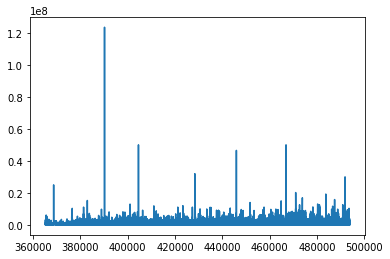

In [9]:
plt.plot(properties['price'])

In [10]:
properties = properties.loc[properties.price < properties.price.quantile(0.9), :]

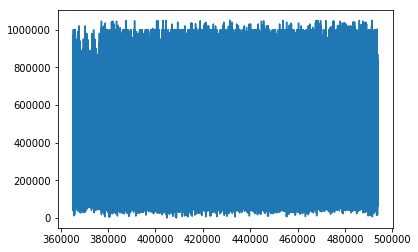

In [11]:
plt.plot(properties['price'])

In [12]:
len(properties.loc[properties.price < properties.price.quantile(0.001), ['price']])

105

In [13]:
properties = properties.loc[properties.price > properties.price.quantile(0.001), :]

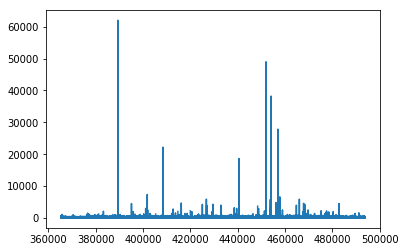

In [14]:
plt.plot(properties['surface_covered_in_m2'])

In [15]:
properties = properties.loc[properties.surface_covered_in_m2 < properties.surface_covered_in_m2.quantile(0.9), :]

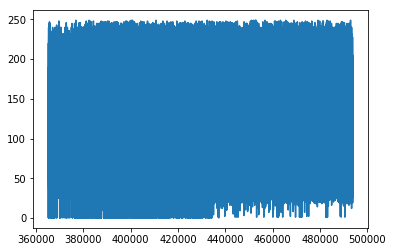

In [16]:
plt.plot(properties['surface_covered_in_m2'])

In [17]:
properties.loc[properties.surface_covered_in_m2 < properties.surface_covered_in_m2.quantile(0.01), ['surface_covered_in_m2']].head(5)

,surface_covered_in_m2
365294,0.0
365324,0.0
365379,0.0
365600,0.0
366056,0.0


In [18]:
properties = properties.loc[properties.surface_covered_in_m2 > properties.surface_covered_in_m2.quantile(0.01)]

In [19]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88040 entries, 365289 to 493835
Data columns (total 30 columns):
Unnamed: 0                    88040 non-null int64
country_name                  88040 non-null object
created_on                    88040 non-null object
currency                      88040 non-null object
description                   88038 non-null object
expenses                      16105 non-null object
extra                         0 non-null object
floor                         7613 non-null float64
geonames_id                   73383 non-null float64
id                            88040 non-null object
image_thumbnail               87315 non-null object
lat                           63607 non-null float64
lat-lon                       63607 non-null object
lon                           63607 non-null float64
operation                     88040 non-null object
place_name                    88027 non-null object
place_with_parent_names       88040 non-null object
pri

In [20]:
print len(properties)
print len(properties[properties['surface_covered_in_m2'].isna()])
print len(properties[properties['surface_total_in_m2'].isna()])
print len(properties[properties['description'].isna()])
print len(properties[properties['place_name'].isna()])
print len(properties[properties['property_type'].isna()])
print len(properties[properties['rooms'].isna()])
print len(properties[properties['floor'].isna()])
print len(properties[properties['expenses'].isna()])
print len(properties[properties['price'].isna()])
print len(properties[properties['lat'].isna()])
print len(properties[properties['lon'].isna()])

88040
0
0
2
13
0
41141
80427
71935
0
24433
24433


### Train y Test base

In [21]:
places_array = propertiesTest['place_name'].drop_duplicates().values
properties = properties[properties['place_name'].isin(places_array)]

In [22]:
baseTrain = properties.loc[:, ['surface_covered_in_m2', 'surface_total_in_m2', 'description', 'place_name', 'property_type', 'price']]

In [23]:
baseTest = propertiesTest.loc[:, ['id','surface_covered_in_m2', 'surface_total_in_m2', 'description', 'place_name', 'property_type']]

### Datos de descripción

In [24]:
def tiene_palabra(df,word,word2):
    t = df
    pool = []
    vectorDes = t['description'].values
    for description in vectorDes:
        description = str(description)
        description = description.lower()
        if word in description or word2 in description:
            pool.append(1)
        else:
            pool.append(0)
    df[str(word)] = pool

In [25]:
def cargar_palabras(df):
    tiene_palabra(df,'pileta','piscina')
    tiene_palabra(df,'garage','cochera')
    tiene_palabra(df,'gimnasio','gym')
    #tiene_palabra(df,'cancha','cancha')
    tiene_palabra(df,'frente',' frente')
    tiene_palabra(df,'contrafrente','contrafrente')
    #tiene_palabra(df,'lavadero','lava')
    tiene_palabra(df,'nuevo','estrenar')
    #tiene_palabra(df,'cuadras','cuadra')
    #tiene_palabra(df,'playroom','sum')
    #tiene_palabra(df,'excelente','hermosa')


    tiene_palabra(df,'centro','centrica')
    tiene_palabra(df,'patio','quincho')
    #tiene_palabra(df,'madero','madero')
    #tiene_palabra(df,'luminoso','iluminacion')
    #tiene_palabra(df,'grande','espacio')
    #tiene_palabra(df,'autopista','autopista')
    tiene_palabra(df,'tren','estacion')
    #tiene_palabra(df,'cocina','comedor')
    #tiene_palabra(df,'seguridad','camaras')
    #tiene_palabra(df,'shopping','cine')

    #tiene_palabra(df,'limpieza','cubiertos')
    tiene_palabra(df,'monoambiente','mono')
    #tiene_palabra(df,'baja','primer')
    #tiene_palabra(df,'parque','verde')
    #tiene_palabra(df,'jardin','jardin')
    #tiene_palabra(df,'living','comedor')
    #tiene_palabra(df,'terraza','balcon')
    tiene_palabra(df,'parrila','parrila')
    tiene_palabra(df,'barrio cerrado','country')
    tiene_palabra(df,'subte','metro')
    tiene_palabra(df,'metrobus','metrobus')
    #tiene_palabra(df,'yacuzzi','jacuzzi')
    tiene_palabra(df,'primer piso','1er piso')
    tiene_palabra(df,'segundo piso','2do piso')
    tiene_palabra(df,'semipiso','semipiso')
    tiene_palabra(df,'piso completo','piso completo')
    tiene_palabra(df,'amueblado','muebles')

In [26]:
train_con_palabras = baseTrain.copy(deep=True)
cargar_palabras(train_con_palabras)

test_con_palabras = baseTest.copy(deep=True)
cargar_palabras(test_con_palabras)

### One hot encoding 

Tipo de propiedad

In [27]:
def es_de_tipo(df,tipo):
    t = df
    encode = []
    tipo = str(tipo)
    tipo = tipo.lower()
    types = t['property_type'].values
    for currentType in types:
        currentType = str(currentType)
        currentType = currentType.lower()
        if currentType == tipo:
            encode.append(1)
        else:
            encode.append(0)
    df[str(tipo)] = encode

In [28]:
types_array = train_con_palabras['property_type'].drop_duplicates().values
types_array = np.array(types_array, dtype=str)
for tipo in types_array:
    es_de_tipo(train_con_palabras, tipo)
    es_de_tipo(test_con_palabras, tipo)

### Encoding de barrios

In [29]:
def es_de_barrio(df,placeName):
    t = df
    pool = []
    placeName = str(placeName)
    placeName = placeName.lower()
    vectorDes = t['place_name'].values
    for place in vectorDes:
        place = str(place)
        place = place.lower()
        if placeName == place:
            pool.append(1)
        else:
            pool.append(0)
    df[str(placeName)] = pool

In [30]:
train_con_barrios = baseTrain
places_array = train_con_barrios['place_name'].drop_duplicates().values
for place in places_array:
    es_de_barrio(train_con_barrios, place)

test_con_barrios = baseTest
places_array = train_con_barrios['place_name'].drop_duplicates().values
for place in places_array:
    es_de_barrio(test_con_barrios, place)

In [31]:
#train_final = train_con_palabras
#test_final = test_con_palabras

train_final = train_con_barrios
test_final = test_con_barrios

for tipo in types_array:
    es_de_tipo(train_final, tipo)
    es_de_tipo(test_final, tipo)

## Cross validation

In [32]:
# Fit estimators
ESTIMATORS = {
    "Extra trees 10": ExtraTreesRegressor(n_estimators=10, random_state=0),
    #"Extra trees 20": ExtraTreesRegressor(n_estimators=20, random_state=0),
    #"Extra trees 30": ExtraTreesRegressor(n_estimators=30, random_state=0),
    #"Extra trees 31": ExtraTreesRegressor(n_estimators=31, random_state=0),
    #"Extra trees 32": ExtraTreesRegressor(n_estimators=32, random_state=0),
    #"Extra trees 33": ExtraTreesRegressor(n_estimators=33, random_state=0),
    #"Extra trees 34": ExtraTreesRegressor(n_estimators=34, random_state=0),
    #"Extra trees 35": ExtraTreesRegressor(n_estimators=35, random_state=0),
    #"Extra trees 36": ExtraTreesRegressor(n_estimators=36, random_state=0),
    #"Extra trees 37": ExtraTreesRegressor(n_estimators=37, random_state=0),
    #"Extra trees 38": ExtraTreesRegressor(n_estimators=38, random_state=0),
    #"Extra trees 39": ExtraTreesRegressor(n_estimators=39, random_state=0),
    #    "SVM" : SVR(),
    #"Random forest 2" : RandomForestRegressor(max_depth=2, random_state=0),
    #"Random forest 5" : RandomForestRegressor(max_depth=5, random_state=0),
    #"Random forest 10" : RandomForestRegressor(max_depth=10, random_state=0),
    #"Random forest 15" : RandomForestRegressor(max_depth=15, random_state=0),
    #"Random forest 30" : RandomForestRegressor(max_depth=30, random_state=0),
    #"Random forest 31" : RandomForestRegressor(max_depth=31, random_state=0),
    #"Random forest 32" : RandomForestRegressor(max_depth=32, random_state=0),
    #"Random forest 33" : RandomForestRegressor(max_depth=33, random_state=0),
    #"Random forest 34" : RandomForestRegressor(max_depth=34, random_state=0),
    #"Random forest 35" : RandomForestRegressor(max_depth=35, random_state=0),
    #"Random forest 36" : RandomForestRegressor(max_depth=36, random_state=0),
    #"Random forest 37" : RandomForestRegressor(max_depth=37, random_state=0),
    #"Random forest 38" : RandomForestRegressor(max_depth=38, random_state=0),
    "Random forest 39" : RandomForestRegressor(max_depth=39, random_state=0),
    #"Random forest 40" : RandomForestRegressor(max_depth=40, random_state=0),
    #"Random forest 41" : RandomForestRegressor(max_depth=41, random_state=0),
    #"Random forest 42" : RandomForestRegressor(max_depth=42, random_state=0),
    #"Random forest 43" : RandomForestRegressor(max_depth=43, random_state=0),
    #"Random forest 44" : RandomForestRegressor(max_depth=44, random_state=0),
    #"Random forest 45" : RandomForestRegressor(max_depth=45, random_state=0),
    #"Random forest 46" : RandomForestRegressor(max_depth=46, random_state=0),
    #"Random forest 47" : RandomForestRegressor(max_depth=47, random_state=0),
    #"Random forest 48" : RandomForestRegressor(max_depth=48, random_state=0),
    #"Random forest 49" : RandomForestRegressor(max_depth=49, random_state=0),    
    #"Random forest 50" : RandomForestRegressor(max_depth=50, random_state=0),    
    #"Random forest 60" : RandomForestRegressor(max_depth=60, random_state=0),        
    #"Random forest 70" : RandomForestRegressor(max_depth=70, random_state=0),            
    "Random forest 100" : RandomForestRegressor(max_depth=100, random_state=0),                
    "Random forest 120" : RandomForestRegressor(max_depth=120, random_state=0),                
    "Random forest 140" : RandomForestRegressor(max_depth=140, random_state=0),                
    "Random forest 160" : RandomForestRegressor(max_depth=160, random_state=0),                
    #"Ada": AdaBoostRegressor(),
    #"Passive": PassiveAggressiveRegressor(random_state=0),
    #"Passive 2": PassiveAggressiveRegressor(random_state=0, C=0.2),
    #"Passive 5": PassiveAggressiveRegressor(random_state=0, C=0.5),
    #"Passive 10": PassiveAggressiveRegressor(random_state=0, C=0.8),
    #"Extra trees 30 - Bootstrap": ExtraTreesRegressor(n_estimators=30, random_state=0, bootstrap=True),    
    #"Extra trees 30 - Bootstrap + OOB": ExtraTreesRegressor(n_estimators=30, random_state=0, bootstrap=True, oob_score=True),    
    #"Extra trees 40": ExtraTreesRegressor(n_estimators=40, random_state=0),
    #"Extra trees 50": ExtraTreesRegressor(n_estimators=50, random_state=0),    
    #"Extra trees 60": ExtraTreesRegressor(n_estimators=60, random_state=0),    
    #"K-nn 5": KNeighborsRegressor(n_neighbors=5),
    #"K-nn 15": KNeighborsRegressor(n_neighbors=15),
    #"K-nn 30": KNeighborsRegressor(n_neighbors=30),
    #"K-nn 50": KNeighborsRegressor(n_neighbors=50),
    #"K-nn 5d": KNeighborsRegressor(n_neighbors=5, weights='distance'),
    #"K-nn 15d": KNeighborsRegressor(n_neighbors=15, weights='distance'),
    #"K-nn 30d": KNeighborsRegressor(n_neighbors=30, weights='distance'),
    #"K-nn 50d": KNeighborsRegressor(n_neighbors=50, weights='distance'),
    #"K-nn 5u": KNeighborsRegressor(n_neighbors=5, weights='uniform'),
    #"K-nn 15u": KNeighborsRegressor(n_neighbors=15, weights='uniform'),
    #"K-nn 30u": KNeighborsRegressor(n_neighbors=30, weights='uniform'),
    #"K-nn 50u": KNeighborsRegressor(n_neighbors=50, weights='uniform'),  
    #"K-nn 5u BT": KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='ball_tree'), 
    #"K-nn 15u BT": KNeighborsRegressor(n_neighbors=15, weights='uniform', algorithm='ball_tree'), 
    #"K-nn 30u BT": KNeighborsRegressor(n_neighbors=30, weights='uniform', algorithm='ball_tree'),     
    #"K-nn 50u BT": KNeighborsRegressor(n_neighbors=50, weights='uniform', algorithm='ball_tree'), 
    #"Linear regression": LinearRegression(),
    #"Ridge": RidgeCV(),
}

In [33]:
#train_cv = train_con_palabras.drop(columns=['description', 'place_name', 'property_type']).sample(frac=1)
#train_cv = train_con_barrios.drop(columns=['description', 'place_name', 'property_type']).sample(frac=1)
def cross_validation_samples(samples, n_samples=14166, train_placed='TOP'):
    samples = samples.copy(deep=True)
    train_cv = samples.drop(columns=['description', 'place_name', 'property_type']).sample(frac=1)
    if(train_placed == 'TOP'):
        train_y_palabras = train_cv.tail(len(train_cv)-n_samples)['price']
        train_x_palabras = train_cv.drop(columns=['price']).tail(len(train_cv)-n_samples)
        validation_y_palabras = train_cv.head(n_samples)['price']
        validation_x_palabras = train_cv.drop(columns=['price']).head(n_samples)
    else:
        train_y_palabras = train_cv.head(len(train_cv)-n_samples)['price']
        train_x_palabras = train_cv.drop(columns=['price']).head(len(train_cv)-n_samples)
        validation_y_palabras = train_cv.tail(n_samples)['price']
        validation_x_palabras = train_cv.drop(columns=['price']).tail(n_samples)
    
    return train_x_palabras, train_y_palabras, validation_x_palabras, validation_y_palabras

In [ ]:
#samples = [14166, 10000, 20000]
#samples_placed = ["TOP", "BOTTOM"]

samples = [7083]
samples_placed = ["TOP"]

for placed in samples_placed:
    for samples_n in samples:
        train_x, train_y, validation_x, validation_y = cross_validation_samples(train_final, n_samples=samples_n, train_placed='TOP')
        y_test_predict = dict()
        print '---------------------- SAMPLES from ' + placed + ':'+ str(samples_n) + '------------------------'
        for name, estimator in ESTIMATORS.items():
            estimator.fit(train_x, train_y)
            y_test_predict[name] = estimator.predict(validation_x)
            print name + ' RMSE: ' + str(mean_squared_error(validation_y, y_test_predict[name]))

---------------------- SAMPLES from TOP:7083------------------------
Random forest 39 RMSE: 9757650496.54


In [ ]:
compare = pd.DataFrame()
compare['pred'] = y_test_predict["Random forest 39"]
compare['real'] = validation_y.values

In [ ]:
compare['diff_abs'] = abs(compare['pred'] - compare['real'])
compare['diff'] = compare['pred'] - compare['real']

In [ ]:
x = compare['diff_abs']
plt.scatter(x, range(0,7083), c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")

In [ ]:
compare.sort_values(by='diff_abs', ascending=False).loc[compare.diff_abs < compare.diff_abs.quantile(0.9),:]

## Predicción real

In [235]:
ESTIMATORS_REAL = {
    "Extra trees 30": ExtraTreesRegressor(n_estimators=30, random_state=0),
    "Extra trees 31": ExtraTreesRegressor(n_estimators=31, random_state=0),
    "Extra trees 32": ExtraTreesRegressor(n_estimators=32, random_state=0),
    "Extra trees 33": ExtraTreesRegressor(n_estimators=33, random_state=0),
    "Extra trees 34": ExtraTreesRegressor(n_estimators=34, random_state=0),
    "Extra trees 35": ExtraTreesRegressor(n_estimators=35, random_state=0),
    "Extra trees 36": ExtraTreesRegressor(n_estimators=36, random_state=0),
    "Extra trees 37": ExtraTreesRegressor(n_estimators=37, random_state=0),
    "Extra trees 38": ExtraTreesRegressor(n_estimators=38, random_state=0),
    "Extra trees 39": ExtraTreesRegressor(n_estimators=39, random_state=0),
    "Random forest 31" : RandomForestRegressor(max_depth=31, random_state=0),
    "Random forest 33" : RandomForestRegressor(max_depth=33, random_state=0),
    "Random forest 35" : RandomForestRegressor(max_depth=35, random_state=0),
    "Random forest 37" : RandomForestRegressor(max_depth=37, random_state=0),
    "Random forest 39" : RandomForestRegressor(max_depth=39, random_state=0),
    "Random forest 41" : RandomForestRegressor(max_depth=41, random_state=0),
    "Random forest 43" : RandomForestRegressor(max_depth=43, random_state=0),
    "Random forest 45" : RandomForestRegressor(max_depth=45, random_state=0),
    "Random forest 47" : RandomForestRegressor(max_depth=47, random_state=0),
    "Random forest 49" : RandomForestRegressor(max_depth=49, random_state=0)
}

In [236]:
#train_x_palabras
#train_y_palabras
for place in places_array:
    es_de_barrio(test_con_palabras, place)
    es_de_barrio(train_con_palabras, place)

In [237]:
for tipo in types_array:
    es_de_tipo(test_con_palabras, tipo)
    es_de_tipo(train_con_palabras, tipo)    

In [238]:
test_con_palabras.drop(columns=['description', 'place_name', 'property_type'], inplace=True)

In [239]:
train_con_palabras.drop(columns=['description', 'place_name', 'property_type'], inplace=True)

In [240]:
ids = test_con_palabras['id']
test_con_palabras.drop(columns=['id'], inplace=True)

In [241]:
train_y = train_con_palabras['price']
train_x = train_con_palabras.drop(columns=['price'])

test_x = test_con_palabras

In [242]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(train_x)
Imputer(axis=1, copy=True, missing_values='NaN', strategy='median', verbose=0)
test_x = imp.transform(test_x)

In [243]:
estimator = RandomForestRegressor(max_depth=39, random_state=0)

In [244]:
estimator.fit(train_x, train_y)
predictions = estimator.predict(test_x)

In [245]:
submit = pd.DataFrame()
submit['price_usd'] = predictions
submit.index = ids

In [246]:
benchmark = pd.read_csv('submission-vara.csv')

In [247]:
mean_squared_error(benchmark['price_usd'].values, predictions)

45661929755.180527

In [248]:
submit.to_csv('submission.csv')